In [26]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from math import radians
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from category_encoders.cat_boost import CatBoostEncoder
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from skopt.plots import plot_convergence
sns.set()

In [2]:
cols=['destination_Region', 'popularity+time', 'timeOnly', 'dayOfWeek', 'hour', 'pathHIndex', 'pathaIndex', 'pathInDegreeIndex', 'pathOutDegreeIndex', 'CountOfGrid', 
      'destLoad', 'destHIndex', 'pickUpLoad',
 'flowType', 'Festival', 'Temp', 'Weather', 'Wind', 'Humidity', 'Barometer', 'Visibility', 'Bus Terminal_pick', 'Business Area_pick',
 'HDB_pick', 'Hospital_pick', 'LRT_pick', 'MRT_pick', 'Mall/Supermarket_pick', 'Other Residentials_pick', 'School/Kindergarten_pick',
 'University/College_pick', 'Bus Terminal_des', 'Business Area_des', 'HDB_des', 'Hospital_des', 'LRT_des', 'MRT_des',
 'Mall/Supermarket_des', 'Other Residentials_des', 'School/Kindergarten_des', 'University/College_des', 'rawlat_pickup', 'rawlng_pickup', 'rawlat_dest', 'rawlng_dest',
 'HarvsineDistance', 'TimeInterval', 'PopularPlace', 'Weekend']

In [3]:
data =pd.read_csv("training_data_v16062020.csv")

In [5]:
trainingData=data[cols]#.select_dtypes(include)

In [7]:
encoder=CatBoostEncoder()
encoder2=CatBoostEncoder()
encoder3=CatBoostEncoder()

In [8]:
trainingData.select_dtypes(include=["object"]).columns

Index(['destination_Region', 'flowType', 'Weather'], dtype='object')

In [276]:
X_train, X_test, y_train, y_test = train_test_split(trainingData[cols],
                                                    data['answer1'],
                                                    test_size = 0.3, 
                                                    random_state = 10)

In [138]:
from skopt import gp_minimize
from skopt.space import Real, Integer,Categorical
from skopt.utils import use_named_args

In [132]:
X_train["destination_Region"]=encoder.fit_transform(X_train["destination_Region"],y_train)
X_train["flowType"]=encoder2.fit_transform(X_train["flowType"],y_train)
X_train["Weather"]=encoder3.fit_transform(X_train["Weather"],y_train)

In [133]:
X_test["destination_Region"]=encoder.transform(X_test["destination_Region"])
X_test["flowType"]=encoder2.transform(X_test["flowType"])
X_test["Weather"]=encoder3.transform(X_test["Weather"])

In [22]:
from xgboost import XGBRegressor

model=XGBRegressor(random_state=0)
# model.fit(X_train2, y_train2)

In [44]:
bds = [Real(0.01, 1.0, 'log-uniform', name='learning_rate'),
 Real(0.01, 5, name='gamma'),
          Integer(1, 50, name="max_depth"),
          Integer(2, 300, name='n_estimators'),
          Integer(1, 10, name='min_samples_leaf')]

In [45]:
@use_named_args(bds)
def objective2(**params):
    model.set_params(**params)
    return -np.mean(cross_val_score(model, X_train, y_train, cv=2, n_jobs=-1, scoring="neg_mean_absolute_error"))

In [46]:
res_gp = gp_minimize(objective2, bds, n_calls=25, random_state=0)

0.021969449275369667 1.7971793131779301 38 183 4


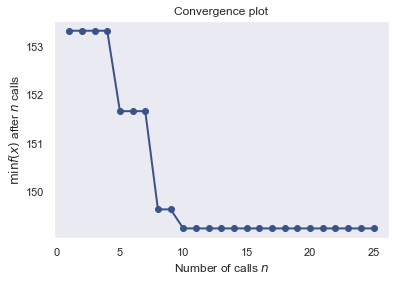

In [47]:
print(res_gp.x[0], res_gp.x[1], res_gp.x[2], res_gp.x[3], res_gp.x[4])
plot_convergence(res_gp)

In [56]:
model=XGBRegressor(learning_rate=0.012674647108651958,gamma=3.070380904824719,max_depth=11
                   ,n_estimators=296,min_samples_leaf=6,random_state=0)

In [57]:
model.fit(X_train, y_train)

[10:58:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\w00478870\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(gamma=3.070380904824719, learning_rate=0.012674647108651958,
             max_depth=11, min_samples_leaf=6, n_estimators=296)

In [58]:
np.sqrt(mean_squared_error(y_train,model.predict(X_train))),mean_absolute_error(y_train,model.predict(X_train))

(139.07539522898824, 93.34244939998705)

In [59]:
np.sqrt(mean_squared_error(y_test,model.predict(X_test))),mean_absolute_error(y_test,model.predict(X_test))

(208.95289486600038, 142.80012122744606)

In [62]:
reg2 = RandomForestRegressor(random_state=0)

space  = [Integer(1, 15, name='max_depth'),
          Integer(10, 100, name="n_estimators"),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    reg2.set_params(**params)
    return -np.mean(cross_val_score(reg2, X_train.fillna(-1), y_train, cv=2, n_jobs=-1, scoring="neg_mean_absolute_error"))

In [63]:
res_gp = gp_minimize(objective, space, n_calls=25, random_state=0)

Best parameters:- max_depth=15- n_estimators=81.000000- min_samples_split=2- min_samples_leaf=8- 


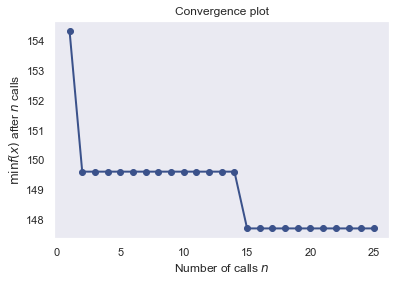

In [64]:
print("""Best parameters:- max_depth=%d- n_estimators=%.6f- min_samples_split=%d- min_samples_leaf=%d- """ % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3]))

plot_convergence(res_gp)

In [90]:
reg2 = RandomForestRegressor(max_depth=15, min_samples_split=2, n_estimators=81,min_samples_leaf=8,random_state=0)

In [91]:
reg2.fit(X_train.fillna(-1), y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=8, n_estimators=81,
                      random_state=0)

In [92]:
np.sqrt(mean_squared_error(y_train,reg2.predict(X_train.fillna(-1)))),mean_absolute_error(y_train,reg2.predict(X_train.fillna(-1)))

(194.45000576322875, 111.98875345676572)

In [93]:
np.sqrt(mean_squared_error(y_test,reg2.predict(X_test.fillna(-1)))),mean_absolute_error(y_test,reg2.predict(X_test.fillna(-1)))

(208.02853479645182, 146.26853242559272)

In [74]:
# np.sqrt(mean_squared_error(data.answer1,reg2.predict(trainingData.fillna(-1))))

In [95]:
trainingDataV2=trainingData.fillna(-1).copy()

In [96]:
trainingDataV2["destination_Region"]=encoder.transform(trainingDataV2["destination_Region"])
trainingDataV2["flowType"]=encoder2.transform(trainingDataV2["flowType"])
trainingDataV2["Weather"]=encoder3.transform(trainingDataV2["Weather"])

In [108]:
from lightgbm import LGBMRegressor

In [109]:
lgb_param_grid = {'n_estimators': [100,400,700,1000],
            'learning_rate': [0.01,0.05],
            'max_depth': [5,10,15],
            'num_leaves': [20,30,50],
            'subsample': [0.5, 0.8],
            'subsample_freq': [20,50]}

In [157]:
lgb_model = LGBMRegressor(random_state=0)

space  = [Categorical(["dart","gbdt"],name="boosting_type"),
          Real(0.01, 0.5, 'log-uniform', name='learning_rate'),
            Real(0.1, 0.8, name='subsample'),
          Integer(1, 20, name="max_depth"),
          Integer(100, 1000, name='n_estimators'),
          Integer(2, 50, name='num_leaves'),
         Integer(2, 50, name='subsample_freq')]

@use_named_args(space)
def objective(**params):
    lgb_model.set_params(**params)
    print(params)
#     print(cross_val_score(lgb_model, X_train, y_train, cv=3, n_jobs=-1, scoring="neg_mean_absolute_error"))
    return -np.mean(cross_val_score(lgb_model, X_train, y_train, cv=3, n_jobs=-1, scoring="neg_mean_absolute_error"))

In [249]:
# for index,item in enumerate(cols):
#     if item in ["destination_Region", "flowType","Weather"]:
#         print(index,item)

In [269]:
from sklearn.base import BaseEstimator
import numpy as np


class ColumnSelector(BaseEstimator):
    """Object for selecting specific columns from a data set.
    Parameters
    ----------
    cols : array-like (default: None)
        A list specifying the feature indices to be selected. For example,
        [1, 4, 5] to select the 2nd, 5th, and 6th feature columns, and
        ['A','C','D'] to select the name of feature columns A, C and D.
        If None, returns all columns in the array.
    drop_axis : bool (default=False)
        Drops last axis if True and the only one column is selected. This
        is useful, e.g., when the ColumnSelector is used for selecting
        only one column and the resulting array should be fed to e.g.,
        a scikit-learn column selector. E.g., instead of returning an
        array with shape (n_samples, 1), drop_axis=True will return an
        aray with shape (n_samples,).
    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/feature_selection/ColumnSelector/
    """

    def __init__(self, cols=None, drop_axis=False):
        self.cols = cols
        self.drop_axis = drop_axis

    def fit_transform(self, X, y=None):
        """ Return a slice of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_slice : shape = [n_samples, k_features]
            Subset of the feature space where k_features <= n_features
        """
        return self.transform(X=X, y=y)

    def transform(self, X, y=None):
        """ Return a slice of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_slice : shape = [n_samples, k_features]
            Subset of the feature space where k_features <= n_features
        """

        # We use the loc or iloc accessor if the input is a pandas dataframe
        if hasattr(X, 'loc') or hasattr(X, 'iloc'):
            if type(self.cols) == tuple:
                self.cols = list(self.cols)
            types = {type(i) for i in self.cols}
            if len(types) > 1:
                raise ValueError(
                    'Elements in `cols` should be all of the same data type.'
                )
            if isinstance(self.cols[0], int):
                t = X.iloc[:, self.cols].values
            elif isinstance(self.cols[0], str):
                t = X.loc[:, self.cols].values
            else:
                raise ValueError(
                    'Elements in `cols` should be either `int` or `str`.'
                )
        else:
            t = X[:, self.cols]

        if t.shape[-1] == 1 and self.drop_axis:
            t = t.reshape(-1)
        if len(t.shape) == 1 and not self.drop_axis:
            t = t[:, np.newaxis]
        return t

    def fit(self, X, y=None):
        """ Mock method. Does nothing.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        self
        """
        return self

In [277]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline,FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer

In [278]:
colsIndex=list(range(1,49))

In [279]:
colsIndex.remove(13)
colsIndex.remove(16)

In [280]:
ct = ColumnTransformer([("ENCODE", CatBoostEncoder(), [0,13,16]),("filler", SimpleImputer(strategy="constant",fill_value=-1), colsIndex)])

In [281]:
finalModel= make_pipeline(ct, LGBMRegressor(boosting_type="dart",learning_rate=0.0716718768261681,subsample=0.8,max_depth=20,n_estimators=1000,num_leaves=50,subsample_freq=2,random_state=0))

In [237]:
ct.fit_transform(data[cols],data["answer1"]).shape

(28000, 49)

In [158]:
res_gp = gp_minimize(objective, space, n_calls=50,random_state=0,verbose=True)

Iteration No: 1 started. Evaluating function at random point.
{'boosting_type': 'gbdt', 'learning_rate': 0.2718830808690578, 'subsample': 0.7005619323359299, 'max_depth': 17, 'n_estimators': 661, 'num_leaves': 20, 'subsample_freq': 16}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.8405
Function value obtained: 161.3607
Current minimum: 161.3607
Iteration No: 2 started. Evaluating function at random point.
{'boosting_type': 'dart', 'learning_rate': 0.02905593571504719, 'subsample': 0.434365582124945, 'max_depth': 16, 'n_estimators': 532, 'num_leaves': 21, 'subsample_freq': 42}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 16.1880
Function value obtained: 170.1425
Current minimum: 161.3607
Iteration No: 3 started. Evaluating function at random point.
{'boosting_type': 'dart', 'learning_rate': 0.12624801786206402, 'subsample': 0.35776907788838364, 'max_depth': 19, 'n_estimators': 226, 'num_leaves': 44, 'subsample_freq': 25}
Iteration No: 3 end

['dart', 0.0716718768261681, 0.8, 20, 1000, 50, 2]


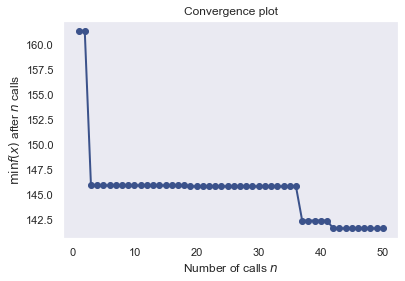

In [159]:
print(res_gp.x)

plot_convergence(res_gp)

In [240]:
len(X_train.columns)

49

In [282]:
finalModel.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ENCODE', CatBoostEncoder(),
                                                  [0, 13, 16]),
                                                 ('filler',
                                                  SimpleImputer(fill_value=-1,
                                                                strategy='constant'),
                                                  [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 14, 15, 17, 18,
                                                   19, 20, 21, 22, 23, 24, 25,
                                                   26, 27, 28, 29, 30, 31, 32, ...])])),
                ('lgbmregressor',
                 LGBMRegressor(boosting_type='dart',
                               learning_rate=0.0716718768261681, max_depth=20,
                               n_estimators=1000, num_leaves=50, random_state=0,
                      

In [266]:
import joblib

In [285]:
joblib.dump(finalModel,"finalLGBMWithPipeline.pkl")

['finalLGBMWithPipeline.pkl']

In [283]:
mean_squared_error(y_test,finalModel.predict(X_test))**0.5

204.55553263730263

In [160]:
lgb_model = LGBMRegressor(boosting_type="dart",learning_rate=0.0716718768261681,subsample=0.8,max_depth=20,n_estimators=1000,num_leaves=50,subsample_freq=2,random_state=0)

lgb_model.fit(X_train, y_train)

In [163]:
lgb_model.score(X_train, y_train),lgb_model.score(X_test, y_test)

(0.8073845597102502, 0.6147060363051555)

In [165]:
mean_squared_error(y_test,lgb_model.predict(X_test))**0.5

204.37424321470695

In [179]:
ggwp=data.groupby("Weather").agg({"answer1":"median"}).sort_values("answer1")#.to_dict()

In [180]:
ggwp.shape

(18, 1)

In [181]:
ggwp.answer1=np.arange(1,19)

In [182]:
ggwp.to_dict()

{'answer1': {'Sprinkles Scattered clouds': 1,
  'Sprinkles Partly sunny': 2,
  'Rain showers Passing clouds': 3,
  'Thunderstorms Scattered clouds': 4,
  'Partly cloudy': 5,
  'Thundershowers Scattered clouds': 6,
  'Passing clouds': 7,
  'Lots of rain Scattered clouds': 8,
  'Scattered showers Partly sunny': 9,
  'Partly sunny': 10,
  'Scattered clouds': 11,
  'Light rain Partly sunny': 12,
  'Thunderstorms Partly sunny': 13,
  'Scattered showers Scattered clouds': 14,
  'Broken clouds': 15,
  'Thunderstorms Passing clouds': 16,
  'Thundershowers Partly sunny': 17,
  'Thunderstorms Broken clouds': 18}}

In [184]:
region_map={'CENTRAL REGION': 1,
  'NORTH-EAST REGION': 2,
  'NORTH REGION': 3,
  'EAST REGION': 4,
  'WEST REGION': 5}

flow_map= {'WEST REGION->WEST REGION': 1,
  'NORTH REGION->NORTH-EAST REGION': 2,
  'NORTH REGION->NORTH REGION': 3,
  'NORTH-EAST REGION->EAST REGION': 4,
  'NORTH-EAST REGION->NORTH-EAST REGION': 5,
  'EAST REGION->EAST REGION': 6,
  'CENTRAL REGION->CENTRAL REGION': 7,
  'EAST REGION->NORTH-EAST REGION': 8,
  'NORTH-EAST REGION->NORTH REGION': 9,
  'EAST REGION->CENTRAL REGION': 10,
  'NORTH-EAST REGION->CENTRAL REGION': 11,
  'WEST REGION->NORTH REGION': 12,
  'WEST REGION->CENTRAL REGION': 13,
  'CENTRAL REGION->NORTH-EAST REGION': 14,
  'CENTRAL REGION->WEST REGION': 15,
  'CENTRAL REGION->EAST REGION': 16,
  'NORTH REGION->WEST REGION': 17,
  'NORTH REGION->CENTRAL REGION': 18,
  'CENTRAL REGION->NORTH REGION': 19,
  'NORTH REGION->EAST REGION': 20,
  'EAST REGION->NORTH REGION': 21,
  'WEST REGION->NORTH-EAST REGION': 22,
  'NORTH-EAST REGION->WEST REGION': 23,
  'WEST REGION->EAST REGION': 24,
  'EAST REGION->WEST REGION': 25}
    
    
weather_map={'Sprinkles Scattered clouds': 1,
  'Sprinkles Partly sunny': 2,
  'Rain showers Passing clouds': 3,
  'Thunderstorms Scattered clouds': 4,
  'Partly cloudy': 5,
  'Thundershowers Scattered clouds': 6,
  'Passing clouds': 7,
  'Lots of rain Scattered clouds': 8,
  'Scattered showers Partly sunny': 9,
  'Partly sunny': 10,
  'Scattered clouds': 11,
  'Light rain Partly sunny': 12,
  'Thunderstorms Partly sunny': 13,
  'Scattered showers Scattered clouds': 14,
  'Broken clouds': 15,
  'Thunderstorms Passing clouds': 16,
  'Thundershowers Partly sunny': 17,
  'Thunderstorms Broken clouds': 18}

In [185]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(trainingData[cols].fillna(-1),
                                                    data['answer1'],
                                                    test_size = 0.3, 
                                                    random_state = 10)

In [188]:
X_train2["destination_Region"]=X_train2["destination_Region"].map(region_map).fillna(-1)
X_train2["flowType"]=X_train2["flowType"].map(flow_map).fillna(-1)
X_train2["Weather"]=X_train2["Weather"].map(weather_map).fillna(-1)

In [191]:
X_test2["destination_Region"]=X_test2["destination_Region"].map(region_map).fillna(-1)
X_test2["flowType"]=X_test2["flowType"].map(flow_map).fillna(-1)
X_test2["Weather"]=X_test2["Weather"].map(weather_map).fillna(-1)

In [189]:
lgb_model = LGBMRegressor(boosting_type="dart",learning_rate=0.0716718768261681,subsample=0.8,max_depth=20,n_estimators=1000,num_leaves=50,subsample_freq=2,random_state=0)

lgb_model.fit(X_train2, y_train2)

LGBMRegressor(boosting_type='dart', learning_rate=0.0716718768261681,
              max_depth=20, n_estimators=1000, num_leaves=50, random_state=0,
              subsample=0.8, subsample_freq=2)

In [192]:
mean_squared_error(y_test2,lgb_model.predict(X_test2))**0.5

205.58361242276095